# Setup

In [ ]:
#Do this at the start of every runtime
!pip install PyWavelets
!pip install pyentrp
!pip install eeglib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 106.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 11.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 81.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for fastdtw: filename=fastdtw-0.3.4-cp311-cp311-linux_x86_64.whl size=542085 sha256=5bae3f7e74dc63e20444ff549d499bc88f9d69b5bb76ef123e0e662e63236e00
  Stored in directory: /root/.cache/pip/wheels/5c/8a/f6/fd3df9a9714677410a5ccbf3ca519e66db4a54a1c46ea95332
  Created wheel for pyedflib: filename=pyedflib-0.1.40-cp311-cp311-linux_x86_64.whl size=2734981 sha256=5aaf5995dda11998f484489145030f6621c69a918242219993e7e76fab05fefb
  Stored in directory: /root/.cache/pip/wheels/8d/df/d6/88ce619bde055ebffebae5380645802eca490817853b60b45b
Successfully built fastdtw pyedflib


In [ ]:
import math
from scipy.stats import skew, kurtosis
import numpy as np
import pywt
import csv
from pyentrp import entropy as ent
import statsmodels.api as sm
import eeglib
import scipy.signal as signal

import scipy.io as spio
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import TensorDataset, DataLoader
from collections import defaultdict
import pandas as pd
import json
import torch.nn.functional as F


from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
import tensorflow as tf
import time
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn import svm

from collections import defaultdict
import pandas as pd
import json

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
! cp -r /content/drive/MyDrive/NinaproDB1 /content

Mounted at /content/drive


## Function

In [ ]:
###### Functions ##########

#This script contains all the required functions to run the classifier model scripts and the Sort script

#Function to segment sEMG data into defined time windows
#takes data to be segmented as input
def windowmaker(data):

        #define window parameters and sampling frequency
        window_length = 0.5
        overlap = 0.7
        fs = 100

        num_samp = int(fs*window_length) #calculate number of samples in each window
        next_window = int(num_samp - num_samp*overlap) #calculate sample number at which next window starts
        windows = []
        window_start = 0
        while window_start + num_samp < len(data): #ensure window length is within data
                window_end = window_start + num_samp  #set end of window
                subwindow = data[window_start:window_end] #generate data window
                windows.append(subwindow) #add subwindow to group of windows
                window_start = window_start + next_window #set starting point of next window
        windows = np.array(windows).transpose(0, 2, 1)
        return windows


def fft_feature_extraction(windows):
    fft_features = []
    for window in windows:
        # Apply FFT along time axis
        fft_magnitude = np.abs(np.fft.rfft(window, axis=1))  # shape: (channels, freq_bins)
        fft_features.append(fft_magnitude)
    return np.array(fft_features)  # shape: (num_windows, channels, freq_bins)


def dwt_feature_extraction(windows, wavelet='db4', level=3):
    dwt_features = []
    for window in windows:
        # window shape: (channels, time)
        channel_coeffs = []
        for channel_data in window:
            # Perform multilevel DWT on one channel
            coeffs = pywt.wavedec(channel_data, wavelet=wavelet, level=level)
            # Concatenate all coefficients (approx + detail)
            coeff_vector = np.concatenate(coeffs)
            channel_coeffs.append(coeff_vector)
        dwt_features.append(channel_coeffs)
    return np.array(dwt_features)  # shape: (num_windows, channels, dwt_feature_len)




#Function to create training, validation and feature CSV files
def makecsv(data,subject, feature_type="time"):

        #define gestures to add to CSV files
        gesturelist = [0,1,2,3,4,5,6,7,8,9]

        #create training set CSV file
        f_name = "subject{}_{}_train_data.csv".format(subject, feature_type)  #create
        f = open(f_name,"w") #open CSV file
        writer = csv.writer(f)
        trainrep = [1,3,5,6,8,9,10]
        for i in gesturelist:  #iterate through gestures
                for k in trainrep:   #iterate through gesture reptitions
                        window_num = 0
                        for window in data["gesture{}".format(i)]["repitition{}".format(k)]:
                                if window_num <1000:  # conditional statement to cap number samples for each gesture if desired
                                        row = []
                                        # Apply FFT if needed
                                        if feature_type == "fft":
                                            window = fft_feature_extraction([window])[0]
                                        if feature_type == "dwt":
                                            window = dwt_feature_extraction([window])[0]
                                        wl = list(window)
                                        gest = [i]
                                        dat = gest + wl
                                        writer.writerow(dat) #add data window and label to CSV
                                        window_num = window_num +1
                print(i,"finished")
        f.close


        #create validation set CSV file
        f_name = "subject{}_{}_validation_data.csv".format(subject, feature_type)
        f = open(f_name,"w") #open CSV file
        writer = csv.writer(f)
        val_rep = [2,4]
        for i in gesturelist:   #iterate through gestures
                for k in val_rep:   #iterate through gesture reptitions
                        window_num = 0
                        for window in data["gesture{}".format(i)]["repitition{}".format(k)]:
                                if window_num <1000:
                                        row = []
                                        # Apply FFT if needed
                                        if feature_type == "fft":
                                            window = fft_feature_extraction([window])[0]
                                        if feature_type == "dwt":
                                            window = dwt_feature_extraction([window])[0]
                                        wl = list(window)
                                        gest = [i]
                                        dat = gest + wl
                                        writer.writerow(dat) #add data window and label to CSV
                                        window_num = window_num +1
        f.close

        #create test set CSV file
        f_name = "subject{}_{}_test_data.csv".format(subject, feature_type)
        f = open(f_name,"w") #open CSV file
        writer = csv.writer(f)
        for i in gesturelist:
                k = 7
                window_num = 0
                for window in data["gesture{}".format(i)]["repitition{}".format(k)]:
                        if window_num <1000:
                                row = []
                                # Apply FFT if needed
                                if feature_type == "fft":
                                    window = fft_feature_extraction([window])[0]
                                if feature_type == "dwt":
                                    window = dwt_feature_extraction([window])[0]
                                wl = list(window)
                                gest = [i]
                                dat = gest + wl
                                writer.writerow(dat) #add data window and label to CSV
                                window_num = window_num +1
        f.close


#Function to read CSV files and create input and target arrays
#for direct input into DL classifier models, takes CSV file and the
#the type of CSV file e.g. "train" as inputs

def inputstargets(subject,type, feature_type="time"):

        #define input and target lists for classifier input
        inputs= []
        targets=[]

        #open csv file specific to subject
        data_file = open("subject{}_{}_{}_data.csv".format(subject,feature_type, type), 'r') #open CSV file from stored location
        data_list = list(csv.reader(data_file)) #read csv file
        data_file.close()

        #extract and convert values from csv file into a list of float input values
        #and integer target values

        for data in data_list: #iterate through data windows stored in CSV
                window = []
                for j in range(1,11):
                        res = data[j].strip('][').split(' ')
                        res2 = []
                        for a in res:
                                if a != '':
                                        float(a)
                                        res2.append(a)
                        res2 = np.asarray(res2, dtype=float)
                        window.append(res2)
                inputs.append(window)
                gesture = int(data[0]) #extract gesture label from CSV
                targets.append(gesture)
        return inputs, targets

#Function to renumber gestures from DB1 Ex2 to be in 0-9 range
def asign_ex2_gesture(gesture):
        if gesture == 5:
                assigned = 1
        elif gesture == 6:
                assigned = 2
        elif gesture == 7:
                assigned = 3
        elif gesture == 11:
                assigned = 4
        elif gesture == 14:
                assigned = 5
        elif gesture == 16:
                assigned = 6
        return assigned

#Function to renumber gestures from DB1 Ex3 to be in 10-14 range
def asign_ex3_gesture(gesture):
        if gesture == 1:
                assigned = 7
        elif gesture == 2:
                assigned = 8
        elif gesture == 14:
                assigned = 9
        elif gesture == 17:
                assigned = 10
        return assigned

## Sort

In [ ]:
##### Sort ###########

#This script loads and segments the sEMG data from the Matlab files provided by the Ninapro DB1 database
#For each of the 27 subjects this produces three CSV files for each subject: training, validation and test.
#An additional three CSV files are also created containing the extracted features of the specified feature set


#Create dictionaries, lists, and arrays for storing and sorting data values
emg_data = {}
spec_emg_data = {}
endlist = []
#List of desired gestures for classification within each exercise - 10 gestures
EX2_gest = [5,6,7,11,14,16]
EX3_gest = [1,2,14,17]

#Define number of subjects
subject_list = list(range(1,28))

#Iterate through all subjects in database and load subject EMG matlab files into dictionaries
for i in subject_list:
    emg_data["subject{}".format(i)]={}
    emg_data["subject{}".format(i)]["ex2"]= spio.loadmat("/content/NinaproDB1/s{}/S{}_A1_E2.mat".format(i,i),variable_names = "emg") #Load files from stored location
    emg_data["subject{}".format(i)]["ex3"]= spio.loadmat("/content/NinaproDB1/s{}/S{}_A1_E3.mat".format(i,i),variable_names = "emg") #Load files from stored location


    #Create nested dictionaries to store gesture classes for corresponding EMG data and specific EMG data for each gesture for each subject

    #Access gesure classes for each subject
    emg_data["subject{}".format(i)]["ex2"]["r"] = {}
    emg_data["subject{}".format(i)]["ex2"]["r"]= spio.loadmat("/content/NinaproDB1/s{}/S{}_A1_E2.mat".format(i,i),variable_names= "restimulus")

    spec_emg_data["subject{}".format(i)]={} #Instantiate nested subject specific EMG dicitionary

    #For each desired gesture in EX2 for specific subject store, corresponding segmented EMG data in nested dictionary
    for l in EX2_gest:
        a = asign_ex2_gesture(l) #Use function to renumber ex2 gestures between 0-9
        spec_emg_data["subject{}".format(i)]["gesture{}".format(a)] = {}
        loclist = [] #Create list to store positions of specific gesture data within exercise 1 data
        loc = np.where(emg_data["subject{}".format(i)]["ex2"]["r"]["restimulus"]==l) #Search through class data to find locations of specific gesture data within exercise 2 data
        #Determine locations of sEMG data for each repetition of the gesture
        loclist.append(loc[0][0])
        for x,y in zip(loc[0][::],loc[0][1::]): #Find gesture locations at the border between the gesture and rest
            if y-x != 1:
                loclist.append(x)
                loclist.append(y)
        loclist.append(loc[0][-1])#Append last value

        #Use gesture 5 positions in order to extract rest position data as there is no specific
        #Exercise for rest data hence it must be extracted from breaks between gesture repetitions
        if l ==5:
            restlist = loclist
            #Add rest data to nested dictionary taken from rests periods between repetitions of the first gesture
            spec_emg_data["subject{}".format(i)]["gesture0"] = {}

            #Segment each rest gesture repetition using "windowmaker" function and store in specific nested dictionary entry
            spec_emg_data["subject{}".format(i)]["gesture0"]["repitition1"] = windowmaker(emg_data["subject{}".format(i)]["ex2"]["emg"][restlist[1]+1:restlist[2]])
            spec_emg_data["subject{}".format(i)]["gesture0"]["repitition2"] = windowmaker(emg_data["subject{}".format(i)]["ex2"]["emg"][restlist[3]+1:restlist[4]])
            spec_emg_data["subject{}".format(i)]["gesture0"]["repitition3"] = windowmaker(emg_data["subject{}".format(i)]["ex2"]["emg"][restlist[5]+1:restlist[6]])
            spec_emg_data["subject{}".format(i)]["gesture0"]["repitition4"] = windowmaker(emg_data["subject{}".format(i)]["ex2"]["emg"][restlist[7]+1:restlist[8]])
            spec_emg_data["subject{}".format(i)]["gesture0"]["repitition5"] = windowmaker(emg_data["subject{}".format(i)]["ex2"]["emg"][restlist[9]+1:restlist[10]])
            spec_emg_data["subject{}".format(i)]["gesture0"]["repitition6"] = windowmaker(emg_data["subject{}".format(i)]["ex2"]["emg"][restlist[11]+1:restlist[12]])
            spec_emg_data["subject{}".format(i)]["gesture0"]["repitition7"] = windowmaker(emg_data["subject{}".format(i)]["ex2"]["emg"][restlist[13]+1:restlist[14]])
            spec_emg_data["subject{}".format(i)]["gesture0"]["repitition8"] = windowmaker(emg_data["subject{}".format(i)]["ex2"]["emg"][restlist[15]+1:restlist[16]])
            spec_emg_data["subject{}".format(i)]["gesture0"]["repitition9"] = windowmaker(emg_data["subject{}".format(i)]["ex2"]["emg"][restlist[17]+1:restlist[18]])


        #Retreive 10th rest repetition from gesture 6 data
        if l ==6:
            restlist = loclist
            spec_emg_data["subject{}".format(i)]["gesture0"]["repitition10"] = windowmaker(emg_data["subject{}".format(i)]["ex2"]["emg"][restlist[1]+1:restlist[2]])


        #Segment each gesture repetition using "windowmaker" function and store it in specific nested dictionary entry
        spec_emg_data["subject{}".format(i)]["gesture{}".format(a)]["repitition1"] = windowmaker(emg_data["subject{}".format(i)]["ex2"]["emg"][loclist[0]:loclist[1]+1])
        spec_emg_data["subject{}".format(i)]["gesture{}".format(a)]["repitition2"] = windowmaker(emg_data["subject{}".format(i)]["ex2"]["emg"][loclist[2]:loclist[3]+1])
        spec_emg_data["subject{}".format(i)]["gesture{}".format(a)]["repitition3"] = windowmaker(emg_data["subject{}".format(i)]["ex2"]["emg"][loclist[4]:loclist[5]+1])
        spec_emg_data["subject{}".format(i)]["gesture{}".format(a)]["repitition4"] = windowmaker(emg_data["subject{}".format(i)]["ex2"]["emg"][loclist[6]:loclist[7]+1])
        spec_emg_data["subject{}".format(i)]["gesture{}".format(a)]["repitition5"] = windowmaker(emg_data["subject{}".format(i)]["ex2"]["emg"][loclist[8]:loclist[9]+1])
        spec_emg_data["subject{}".format(i)]["gesture{}".format(a)]["repitition6"] = windowmaker(emg_data["subject{}".format(i)]["ex2"]["emg"][loclist[10]:loclist[11]+1])
        spec_emg_data["subject{}".format(i)]["gesture{}".format(a)]["repitition7"] = windowmaker(emg_data["subject{}".format(i)]["ex2"]["emg"][loclist[12]:loclist[13]+1])
        spec_emg_data["subject{}".format(i)]["gesture{}".format(a)]["repitition8"] = windowmaker(emg_data["subject{}".format(i)]["ex2"]["emg"][loclist[14]:loclist[15]+1])
        spec_emg_data["subject{}".format(i)]["gesture{}".format(a)]["repitition9"] = windowmaker(emg_data["subject{}".format(i)]["ex2"]["emg"][loclist[16]:loclist[17]+1])
        spec_emg_data["subject{}".format(i)]["gesture{}".format(a)]["repitition10"] = windowmaker(emg_data["subject{}".format(i)]["ex2"]["emg"][loclist[18]:loclist[19]+1])


    #Delete unused variables to increase computational efficiency
    del emg_data["subject{}".format(i)]["ex2"]

    ##Repeat same process for EX3 gestures ##

    #Access gesture classes for each subject
    emg_data["subject{}".format(i)]["ex3"]["r"]= {}
    emg_data["subject{}".format(i)]["ex3"]["r"] = spio.loadmat("/content/NinaproDB1/s{}/S{}_A1_E3.mat".format(i,i),variable_names = "restimulus")


    for j in EX3_gest:
        b = asign_ex3_gesture(j) #Use function to renumber ex3 gestures between 10-14
        spec_emg_data["subject{}".format(i)]["gesture{}".format(b)] = {}
        loclist = [] #Create list to store positions of specific gesture data within exercise 3 data
        loc = np.where(emg_data["subject{}".format(i)]["ex3"]["r"]["restimulus"]==j) #Search through class data to find locations of specific gesture data within exercise 3 data
        #Determine locations of sEMG data for each reptiion of the gesture
        loclist.append(loc[0][0])
        for x,y in zip(loc[0][::],loc[0][1::]):#Find gesture locations at the border between the gesture and rest
            if y-x != 1:
                loclist.append(x)
                loclist.append(y)

        loclist.append(loc[0][-1]) #Append last value

        #Segment each gesture repetition using "windowmaker" function and store in specific nested dictionary entry
        spec_emg_data["subject{}".format(i)]["gesture{}".format(b)]["repitition1"] = windowmaker(emg_data["subject{}".format(i)]["ex3"]["emg"][loclist[0]:loclist[1]+1])
        spec_emg_data["subject{}".format(i)]["gesture{}".format(b)]["repitition2"] = windowmaker(emg_data["subject{}".format(i)]["ex3"]["emg"][loclist[2]:loclist[3]+1])
        spec_emg_data["subject{}".format(i)]["gesture{}".format(b)]["repitition3"] = windowmaker(emg_data["subject{}".format(i)]["ex3"]["emg"][loclist[4]:loclist[5]+1])
        spec_emg_data["subject{}".format(i)]["gesture{}".format(b)]["repitition4"] = windowmaker(emg_data["subject{}".format(i)]["ex3"]["emg"][loclist[6]:loclist[7]+1])
        spec_emg_data["subject{}".format(i)]["gesture{}".format(b)]["repitition5"] = windowmaker(emg_data["subject{}".format(i)]["ex3"]["emg"][loclist[8]:loclist[9]+1])
        spec_emg_data["subject{}".format(i)]["gesture{}".format(b)]["repitition6"] = windowmaker(emg_data["subject{}".format(i)]["ex3"]["emg"][loclist[10]:loclist[11]+1])
        spec_emg_data["subject{}".format(i)]["gesture{}".format(b)]["repitition7"] = windowmaker(emg_data["subject{}".format(i)]["ex3"]["emg"][loclist[12]:loclist[13]+1])
        spec_emg_data["subject{}".format(i)]["gesture{}".format(b)]["repitition8"] = windowmaker(emg_data["subject{}".format(i)]["ex3"]["emg"][loclist[14]:loclist[15]+1])
        spec_emg_data["subject{}".format(i)]["gesture{}".format(b)]["repitition9"] = windowmaker(emg_data["subject{}".format(i)]["ex3"]["emg"][loclist[16]:loclist[17]+1])
        spec_emg_data["subject{}".format(i)]["gesture{}".format(b)]["repitition10"] = windowmaker(emg_data["subject{}".format(i)]["ex3"]["emg"][loclist[18]:loclist[19]+1])

    #Delete unused variables to increase computational efficiency
    del emg_data["subject{}".format(i)]

    #create training, validation and test CSV files contianing segemented sEMG gesture data
    #CHANGE THIS to get diff types of data
    makecsv(spec_emg_data["subject{}".format(i)],i)
    #makecsv(spec_emg_data["subject{}".format(i)],i, "fft")
    #makecsv(spec_emg_data["subject{}".format(i)],i, "dwt")

   #Delete surplus variables to increase computational efficiency
    del spec_emg_data["subject{}".format(i)]

0 finished
1 finished
2 finished
3 finished
4 finished
5 finished
6 finished
7 finished
8 finished
9 finished
0 finished
1 finished
2 finished
3 finished
4 finished
5 finished
6 finished
7 finished
8 finished
9 finished
0 finished
1 finished
2 finished
3 finished
4 finished
5 finished
6 finished
7 finished
8 finished
9 finished
0 finished
1 finished
2 finished
3 finished
4 finished
5 finished
6 finished
7 finished
8 finished
9 finished
0 finished
1 finished
2 finished
3 finished
4 finished
5 finished
6 finished
7 finished
8 finished
9 finished
0 finished
1 finished
2 finished
3 finished
4 finished
5 finished
6 finished
7 finished
8 finished
9 finished
0 finished
1 finished
2 finished
3 finished
4 finished
5 finished
6 finished
7 finished
8 finished
9 finished
0 finished
1 finished
2 finished
3 finished
4 finished
5 finished
6 finished
7 finished
8 finished
9 finished
0 finished
1 finished
2 finished
3 finished
4 finished
5 finished
6 finished
7 finished
8 finished
9 finished
0 finished

# Self Attention

In [ ]:
class ChannelAttention(nn.Module):
    def __init__(self, channels, reduction=16):
        super(ChannelAttention, self).__init__()

        #Calculate average and max pool for each channel - "Squeeze"
        self.avg_pool = nn.AdaptiveAvgPool1d(1)
        self.max_pool = nn.AdaptiveMaxPool1d(1)

        #Put the pools through an MLP - "Excitation"
        self.fc = nn.Sequential(
            nn.Linear(channels, channels // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channels // reduction, channels, bias=False)
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        b, c, _ = x.size()
        avg_out = self.fc(self.avg_pool(x).view(b, c))
        max_out = self.fc(self.max_pool(x).view(b, c))
        channel_att = self.sigmoid(avg_out + max_out).view(b, c, 1) #Add average and max out and apply sigmoid - gives us channel attention weights
        return x * channel_att #Apply channel attention

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        self.conv = nn.Conv1d(2, 1, kernel_size=kernel_size, padding=kernel_size//2) #Perform 1d convolution - gives us time domain
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        attention_input = torch.cat([avg_out, max_out], dim=1) #Concatenate avg and max out

        attention_map = self.sigmoid(self.conv(attention_input)) #Perform convolution and sigmoid, giving us temporal attention weights

        return x * attention_map #Apply temporal attention

# Middle CNN Model


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class middleCNN(nn.Module):
    def __init__(self, input_channels, num_classes, dropout_rate=0.3):
        super(middleCNN, self).__init__()

        #First convolution block
        self.conv1 = nn.Conv1d(input_channels, 32, kernel_size=3, padding=1, bias=False)
        self.bn1 = nn.BatchNorm1d(32)
        self.pool1 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.channel_attention = ChannelAttention(32) #Add Channel Attention after first convolution block

        #Second convolution block
        self.conv2 = nn.Conv1d(32, 64, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm1d(64)
        self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.spatial_attention = SpatialAttention() #Add Spatial (Temporal) Attention after second convolution block
        self.dropout1 = nn.Dropout(dropout_rate)

        #Third convolution block
        self.conv3 = nn.Conv1d(64, 128, kernel_size=3, padding=1, bias=False)
        self.bn3 = nn.BatchNorm1d(128)
        self.pool3 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.dropout2 = nn.Dropout(dropout_rate)

        #Global pooling and FC layers
        self.global_avg_pool = nn.AdaptiveAvgPool1d(1)
        self.fc1 = nn.Linear(128, 256)
        self.fc2 = nn.Linear(256, 256)
        self.dropout3 = nn.Dropout(dropout_rate)
        self.out = nn.Linear(256, num_classes)

    def forward(self, x):
        #First convolution block
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool1(x)
        x = self.channel_attention(x)

        #Second convolution block
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool2(x)
        x = self.spatial_attention(x)
        x = self.dropout1(x)

        #Third convolution block
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool3(x)
        x = self.dropout2(x)

        #Global pooling and FC layers
        x = self.global_avg_pool(x).squeeze(-1)
        x = F.relu(self.fc1(x))
        x = self.dropout3(x)
        x = F.relu(self.fc2(x))
        x = self.dropout3(x)
        x = self.out(x)
        return x



 Epoch 1: Learning Rate = 0.001
Subject 1 | Epoch 1/200 | Train Loss: 2.1328 | Train Acc: 0.2254 | Val Loss: 2.1641 | Val Acc: 0.1914

 Epoch 2: Learning Rate = 0.001
Subject 1 | Epoch 2/200 | Train Loss: 1.6369 | Train Acc: 0.4082 | Val Loss: 1.4849 | Val Acc: 0.5038

 Epoch 3: Learning Rate = 0.001
Subject 1 | Epoch 3/200 | Train Loss: 1.1759 | Train Acc: 0.5618 | Val Loss: 1.1074 | Val Acc: 0.6348

 Epoch 4: Learning Rate = 0.001
Subject 1 | Epoch 4/200 | Train Loss: 0.9096 | Train Acc: 0.6643 | Val Loss: 0.8316 | Val Acc: 0.7305

 Epoch 5: Learning Rate = 0.001
Subject 1 | Epoch 5/200 | Train Loss: 0.7258 | Train Acc: 0.7397 | Val Loss: 0.6903 | Val Acc: 0.8136

 Epoch 6: Learning Rate = 0.001
Subject 1 | Epoch 6/200 | Train Loss: 0.6019 | Train Acc: 0.8018 | Val Loss: 0.7775 | Val Acc: 0.8237

 Epoch 7: Learning Rate = 0.001
Subject 1 | Epoch 7/200 | Train Loss: 0.5534 | Train Acc: 0.8172 | Val Loss: 0.6919 | Val Acc: 0.8161

 Epoch 8: Learning Rate = 0.001
Subject 1 | Epoch 8/20

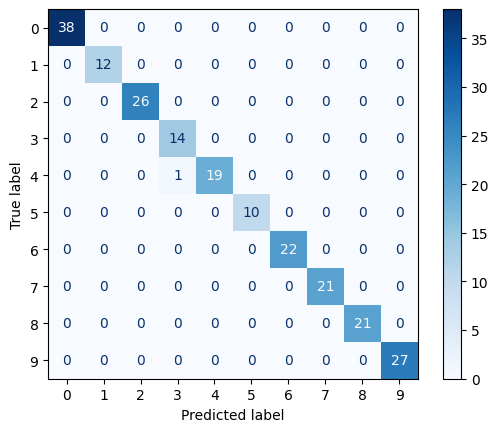


 Epoch 1: Learning Rate = 0.001
Subject 2 | Epoch 1/200 | Train Loss: 2.1003 | Train Acc: 0.2347 | Val Loss: 2.0176 | Val Acc: 0.3363

 Epoch 2: Learning Rate = 0.001
Subject 2 | Epoch 2/200 | Train Loss: 1.4893 | Train Acc: 0.4786 | Val Loss: 1.2526 | Val Acc: 0.5642

 Epoch 3: Learning Rate = 0.001
Subject 2 | Epoch 3/200 | Train Loss: 1.0398 | Train Acc: 0.6279 | Val Loss: 0.9702 | Val Acc: 0.6770

 Epoch 4: Learning Rate = 0.001
Subject 2 | Epoch 4/200 | Train Loss: 0.7826 | Train Acc: 0.7226 | Val Loss: 0.7288 | Val Acc: 0.7611

 Epoch 5: Learning Rate = 0.001
Subject 2 | Epoch 5/200 | Train Loss: 0.6351 | Train Acc: 0.7725 | Val Loss: 0.6075 | Val Acc: 0.7898

 Epoch 6: Learning Rate = 0.001
Subject 2 | Epoch 6/200 | Train Loss: 0.5865 | Train Acc: 0.7916 | Val Loss: 0.5708 | Val Acc: 0.8053

 Epoch 7: Learning Rate = 0.001
Subject 2 | Epoch 7/200 | Train Loss: 0.5272 | Train Acc: 0.8264 | Val Loss: 0.5371 | Val Acc: 0.8097

 Epoch 8: Learning Rate = 0.001
Subject 2 | Epoch 8/20

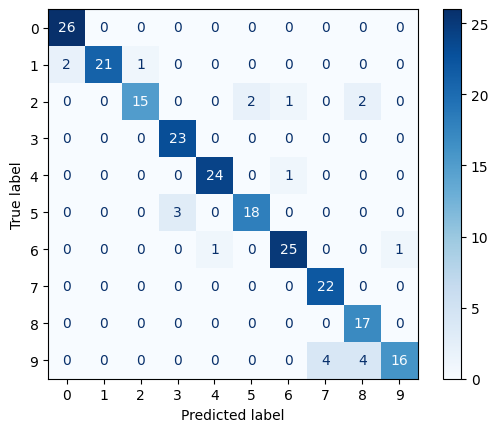


 Epoch 1: Learning Rate = 0.001
Subject 3 | Epoch 1/200 | Train Loss: 2.0595 | Train Acc: 0.3024 | Val Loss: 2.0518 | Val Acc: 0.3889

 Epoch 2: Learning Rate = 0.001
Subject 3 | Epoch 2/200 | Train Loss: 1.3845 | Train Acc: 0.5361 | Val Loss: 1.1064 | Val Acc: 0.6208

 Epoch 3: Learning Rate = 0.001
Subject 3 | Epoch 3/200 | Train Loss: 1.0330 | Train Acc: 0.6388 | Val Loss: 0.8166 | Val Acc: 0.7343

 Epoch 4: Learning Rate = 0.001
Subject 3 | Epoch 4/200 | Train Loss: 0.9388 | Train Acc: 0.6806 | Val Loss: 0.7913 | Val Acc: 0.7271

 Epoch 5: Learning Rate = 0.001
Subject 3 | Epoch 5/200 | Train Loss: 0.7768 | Train Acc: 0.7443 | Val Loss: 0.6590 | Val Acc: 0.7802

 Epoch 6: Learning Rate = 0.001
Subject 3 | Epoch 6/200 | Train Loss: 0.7159 | Train Acc: 0.7684 | Val Loss: 0.6611 | Val Acc: 0.7899

 Epoch 7: Learning Rate = 0.001
Subject 3 | Epoch 7/200 | Train Loss: 0.6955 | Train Acc: 0.7606 | Val Loss: 0.6935 | Val Acc: 0.7826

 Epoch 8: Learning Rate = 0.001
Subject 3 | Epoch 8/20

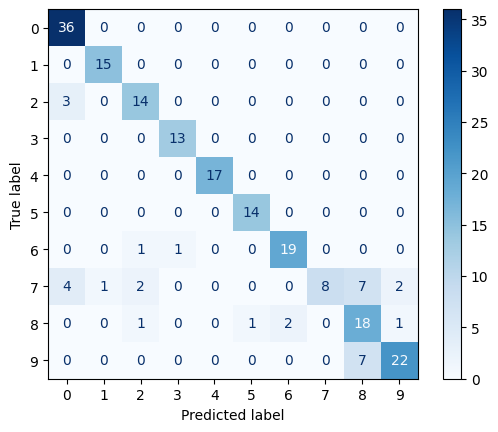


 Epoch 1: Learning Rate = 0.001
Subject 4 | Epoch 1/200 | Train Loss: 2.0856 | Train Acc: 0.2486 | Val Loss: 2.0334 | Val Acc: 0.3995

 Epoch 2: Learning Rate = 0.001
Subject 4 | Epoch 2/200 | Train Loss: 1.7268 | Train Acc: 0.3854 | Val Loss: 1.5328 | Val Acc: 0.4743

 Epoch 3: Learning Rate = 0.001
Subject 4 | Epoch 3/200 | Train Loss: 1.5156 | Train Acc: 0.4685 | Val Loss: 1.2663 | Val Acc: 0.5771

 Epoch 4: Learning Rate = 0.001
Subject 4 | Epoch 4/200 | Train Loss: 1.3706 | Train Acc: 0.5091 | Val Loss: 1.0927 | Val Acc: 0.6168

 Epoch 5: Learning Rate = 0.001
Subject 4 | Epoch 5/200 | Train Loss: 1.3021 | Train Acc: 0.5334 | Val Loss: 1.0625 | Val Acc: 0.6308

 Epoch 6: Learning Rate = 0.001
Subject 4 | Epoch 6/200 | Train Loss: 1.2916 | Train Acc: 0.5353 | Val Loss: 1.0144 | Val Acc: 0.6379

 Epoch 7: Learning Rate = 0.001
Subject 4 | Epoch 7/200 | Train Loss: 1.1739 | Train Acc: 0.5778 | Val Loss: 1.0275 | Val Acc: 0.6519

 Epoch 8: Learning Rate = 0.001
Subject 4 | Epoch 8/20

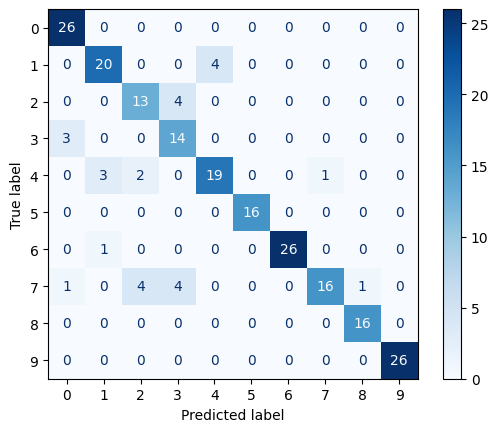


 Epoch 1: Learning Rate = 0.001
Subject 5 | Epoch 1/200 | Train Loss: 2.0452 | Train Acc: 0.2274 | Val Loss: 1.9154 | Val Acc: 0.3333

 Epoch 2: Learning Rate = 0.001
Subject 5 | Epoch 2/200 | Train Loss: 1.5444 | Train Acc: 0.3943 | Val Loss: 1.2726 | Val Acc: 0.4765

 Epoch 3: Learning Rate = 0.001
Subject 5 | Epoch 3/200 | Train Loss: 1.2564 | Train Acc: 0.5255 | Val Loss: 0.9784 | Val Acc: 0.6309

 Epoch 4: Learning Rate = 0.001
Subject 5 | Epoch 4/200 | Train Loss: 1.0538 | Train Acc: 0.6089 | Val Loss: 0.8172 | Val Acc: 0.6823

 Epoch 5: Learning Rate = 0.001
Subject 5 | Epoch 5/200 | Train Loss: 0.8482 | Train Acc: 0.7006 | Val Loss: 0.7204 | Val Acc: 0.7405

 Epoch 6: Learning Rate = 0.001
Subject 5 | Epoch 6/200 | Train Loss: 0.8075 | Train Acc: 0.7261 | Val Loss: 0.6986 | Val Acc: 0.7338

 Epoch 7: Learning Rate = 0.001
Subject 5 | Epoch 7/200 | Train Loss: 0.7383 | Train Acc: 0.7363 | Val Loss: 0.6183 | Val Acc: 0.7427

 Epoch 8: Learning Rate = 0.001
Subject 5 | Epoch 8/20

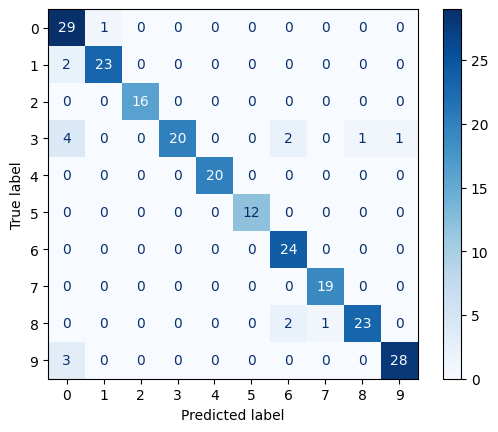


 Epoch 1: Learning Rate = 0.001
Subject 6 | Epoch 1/200 | Train Loss: 2.0905 | Train Acc: 0.2036 | Val Loss: 2.0740 | Val Acc: 0.3022

 Epoch 2: Learning Rate = 0.001
Subject 6 | Epoch 2/200 | Train Loss: 1.6663 | Train Acc: 0.3982 | Val Loss: 1.5072 | Val Acc: 0.5326

 Epoch 3: Learning Rate = 0.001
Subject 6 | Epoch 3/200 | Train Loss: 1.2659 | Train Acc: 0.5743 | Val Loss: 0.9858 | Val Acc: 0.7000

 Epoch 4: Learning Rate = 0.001
Subject 6 | Epoch 4/200 | Train Loss: 0.9923 | Train Acc: 0.6587 | Val Loss: 0.7811 | Val Acc: 0.7630

 Epoch 5: Learning Rate = 0.001
Subject 6 | Epoch 5/200 | Train Loss: 0.8832 | Train Acc: 0.7024 | Val Loss: 0.7592 | Val Acc: 0.7391

 Epoch 6: Learning Rate = 0.001
Subject 6 | Epoch 6/200 | Train Loss: 0.8165 | Train Acc: 0.7401 | Val Loss: 0.7287 | Val Acc: 0.7783

 Epoch 7: Learning Rate = 0.001
Subject 6 | Epoch 7/200 | Train Loss: 0.8073 | Train Acc: 0.7353 | Val Loss: 0.7191 | Val Acc: 0.7587

 Epoch 8: Learning Rate = 0.001
Subject 6 | Epoch 8/20

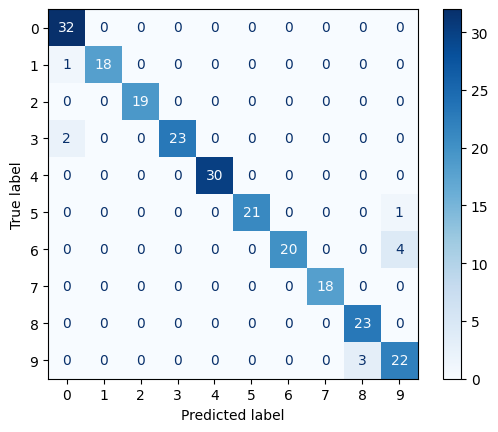


 Epoch 1: Learning Rate = 0.001
Subject 7 | Epoch 1/200 | Train Loss: 2.0228 | Train Acc: 0.2995 | Val Loss: 1.9625 | Val Acc: 0.2841

 Epoch 2: Learning Rate = 0.001
Subject 7 | Epoch 2/200 | Train Loss: 1.3720 | Train Acc: 0.5040 | Val Loss: 1.1871 | Val Acc: 0.5636

 Epoch 3: Learning Rate = 0.001
Subject 7 | Epoch 3/200 | Train Loss: 1.0224 | Train Acc: 0.6207 | Val Loss: 1.1203 | Val Acc: 0.6682

 Epoch 4: Learning Rate = 0.001
Subject 7 | Epoch 4/200 | Train Loss: 0.8617 | Train Acc: 0.6867 | Val Loss: 0.9110 | Val Acc: 0.6977

 Epoch 5: Learning Rate = 0.001
Subject 7 | Epoch 5/200 | Train Loss: 0.7236 | Train Acc: 0.7375 | Val Loss: 0.7844 | Val Acc: 0.7818

 Epoch 6: Learning Rate = 0.001
Subject 7 | Epoch 6/200 | Train Loss: 0.6194 | Train Acc: 0.7790 | Val Loss: 0.6681 | Val Acc: 0.8227

 Epoch 7: Learning Rate = 0.001
Subject 7 | Epoch 7/200 | Train Loss: 0.5864 | Train Acc: 0.7810 | Val Loss: 0.6902 | Val Acc: 0.7864

 Epoch 8: Learning Rate = 0.001
Subject 7 | Epoch 8/20

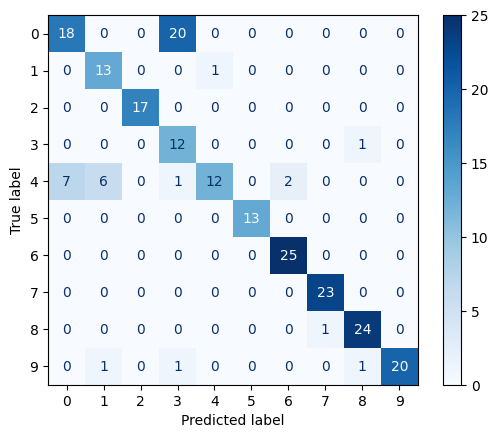


 Epoch 1: Learning Rate = 0.001
Subject 8 | Epoch 1/200 | Train Loss: 2.1112 | Train Acc: 0.2451 | Val Loss: 2.1806 | Val Acc: 0.2183

 Epoch 2: Learning Rate = 0.001
Subject 8 | Epoch 2/200 | Train Loss: 1.5378 | Train Acc: 0.4656 | Val Loss: 1.3218 | Val Acc: 0.5786

 Epoch 3: Learning Rate = 0.001
Subject 8 | Epoch 3/200 | Train Loss: 1.0685 | Train Acc: 0.6283 | Val Loss: 0.8804 | Val Acc: 0.6507

 Epoch 4: Learning Rate = 0.001
Subject 8 | Epoch 4/200 | Train Loss: 0.8412 | Train Acc: 0.7093 | Val Loss: 0.7751 | Val Acc: 0.7205

 Epoch 5: Learning Rate = 0.001
Subject 8 | Epoch 5/200 | Train Loss: 0.6412 | Train Acc: 0.7794 | Val Loss: 0.6923 | Val Acc: 0.7489

 Epoch 6: Learning Rate = 0.001
Subject 8 | Epoch 6/200 | Train Loss: 0.5773 | Train Acc: 0.8080 | Val Loss: 0.5419 | Val Acc: 0.8231

 Epoch 7: Learning Rate = 0.001
Subject 8 | Epoch 7/200 | Train Loss: 0.5095 | Train Acc: 0.8285 | Val Loss: 0.5432 | Val Acc: 0.8297

 Epoch 8: Learning Rate = 0.001
Subject 8 | Epoch 8/20

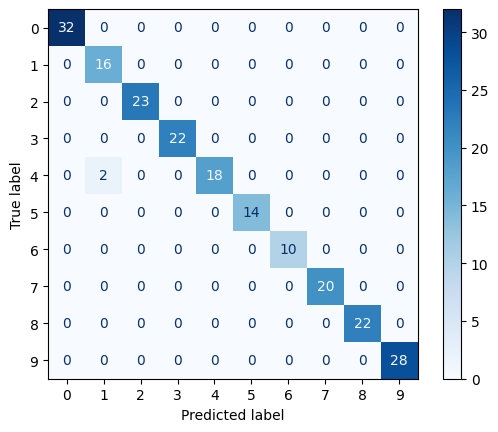


 Epoch 1: Learning Rate = 0.001
Subject 9 | Epoch 1/200 | Train Loss: 2.0983 | Train Acc: 0.2268 | Val Loss: 2.1116 | Val Acc: 0.2217

 Epoch 2: Learning Rate = 0.001
Subject 9 | Epoch 2/200 | Train Loss: 1.5508 | Train Acc: 0.4229 | Val Loss: 1.2841 | Val Acc: 0.5660

 Epoch 3: Learning Rate = 0.001
Subject 9 | Epoch 3/200 | Train Loss: 1.1389 | Train Acc: 0.5757 | Val Loss: 0.9087 | Val Acc: 0.7193

 Epoch 4: Learning Rate = 0.001
Subject 9 | Epoch 4/200 | Train Loss: 0.8886 | Train Acc: 0.6699 | Val Loss: 0.7157 | Val Acc: 0.7830

 Epoch 5: Learning Rate = 0.001
Subject 9 | Epoch 5/200 | Train Loss: 0.8072 | Train Acc: 0.7013 | Val Loss: 0.6231 | Val Acc: 0.8278

 Epoch 6: Learning Rate = 0.001
Subject 9 | Epoch 6/200 | Train Loss: 0.7445 | Train Acc: 0.7376 | Val Loss: 0.5537 | Val Acc: 0.8042

 Epoch 7: Learning Rate = 0.001
Subject 9 | Epoch 7/200 | Train Loss: 0.6898 | Train Acc: 0.7585 | Val Loss: 0.5000 | Val Acc: 0.8656

 Epoch 8: Learning Rate = 0.001
Subject 9 | Epoch 8/20

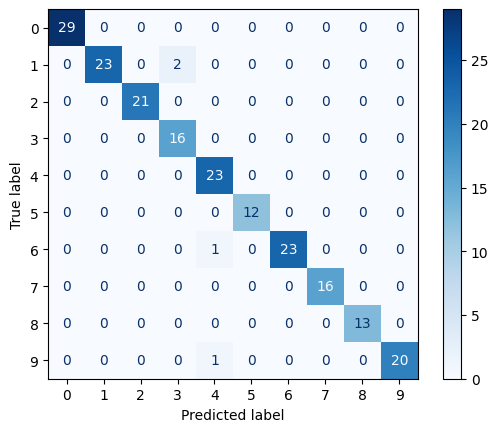


 Epoch 1: Learning Rate = 0.001
Subject 10 | Epoch 1/200 | Train Loss: 2.1589 | Train Acc: 0.1829 | Val Loss: 2.1135 | Val Acc: 0.2516

 Epoch 2: Learning Rate = 0.001
Subject 10 | Epoch 2/200 | Train Loss: 1.7671 | Train Acc: 0.3439 | Val Loss: 1.5432 | Val Acc: 0.4267

 Epoch 3: Learning Rate = 0.001
Subject 10 | Epoch 3/200 | Train Loss: 1.5151 | Train Acc: 0.4557 | Val Loss: 1.2468 | Val Acc: 0.5339

 Epoch 4: Learning Rate = 0.001
Subject 10 | Epoch 4/200 | Train Loss: 1.3409 | Train Acc: 0.5113 | Val Loss: 1.0797 | Val Acc: 0.5777

 Epoch 5: Learning Rate = 0.001
Subject 10 | Epoch 5/200 | Train Loss: 1.2075 | Train Acc: 0.5824 | Val Loss: 0.9488 | Val Acc: 0.7068

 Epoch 6: Learning Rate = 0.001
Subject 10 | Epoch 6/200 | Train Loss: 1.1353 | Train Acc: 0.5882 | Val Loss: 0.8547 | Val Acc: 0.7287

 Epoch 7: Learning Rate = 0.001
Subject 10 | Epoch 7/200 | Train Loss: 1.0143 | Train Acc: 0.6445 | Val Loss: 0.7721 | Val Acc: 0.7702

 Epoch 8: Learning Rate = 0.001
Subject 10 | Ep

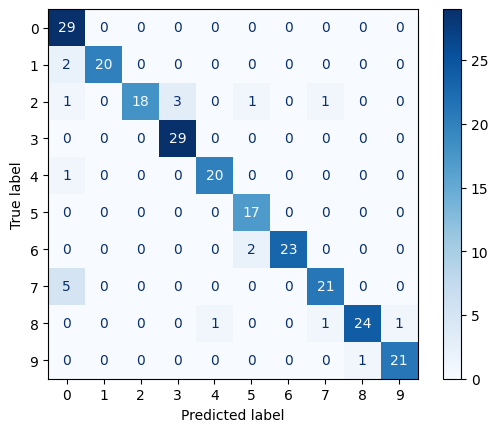


 Epoch 1: Learning Rate = 0.001
Subject 11 | Epoch 1/200 | Train Loss: 2.1136 | Train Acc: 0.2110 | Val Loss: 2.0381 | Val Acc: 0.2287

 Epoch 2: Learning Rate = 0.001
Subject 11 | Epoch 2/200 | Train Loss: 1.6728 | Train Acc: 0.3957 | Val Loss: 1.4810 | Val Acc: 0.4636

 Epoch 3: Learning Rate = 0.001
Subject 11 | Epoch 3/200 | Train Loss: 1.4704 | Train Acc: 0.4660 | Val Loss: 1.2886 | Val Acc: 0.5800

 Epoch 4: Learning Rate = 0.001
Subject 11 | Epoch 4/200 | Train Loss: 1.3209 | Train Acc: 0.5191 | Val Loss: 1.2306 | Val Acc: 0.5863

 Epoch 5: Learning Rate = 0.001
Subject 11 | Epoch 5/200 | Train Loss: 1.1775 | Train Acc: 0.6013 | Val Loss: 1.1010 | Val Acc: 0.6403

 Epoch 6: Learning Rate = 0.001
Subject 11 | Epoch 6/200 | Train Loss: 1.1175 | Train Acc: 0.6168 | Val Loss: 1.1110 | Val Acc: 0.6383

 Epoch 7: Learning Rate = 0.001
Subject 11 | Epoch 7/200 | Train Loss: 1.1153 | Train Acc: 0.6162 | Val Loss: 1.0107 | Val Acc: 0.6590

 Epoch 8: Learning Rate = 0.001
Subject 11 | Ep

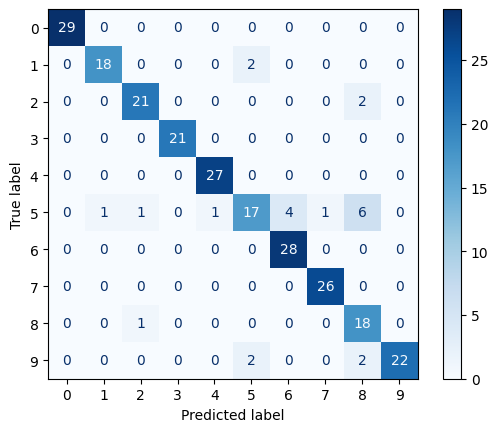


 Epoch 1: Learning Rate = 0.001
Subject 12 | Epoch 1/200 | Train Loss: 2.1000 | Train Acc: 0.2455 | Val Loss: 2.0760 | Val Acc: 0.2527

 Epoch 2: Learning Rate = 0.001
Subject 12 | Epoch 2/200 | Train Loss: 1.5384 | Train Acc: 0.4635 | Val Loss: 1.2713 | Val Acc: 0.6264

 Epoch 3: Learning Rate = 0.001
Subject 12 | Epoch 3/200 | Train Loss: 1.1304 | Train Acc: 0.6120 | Val Loss: 1.0025 | Val Acc: 0.6857

 Epoch 4: Learning Rate = 0.001
Subject 12 | Epoch 4/200 | Train Loss: 0.9716 | Train Acc: 0.6562 | Val Loss: 0.7700 | Val Acc: 0.7560

 Epoch 5: Learning Rate = 0.001
Subject 12 | Epoch 5/200 | Train Loss: 0.7843 | Train Acc: 0.7398 | Val Loss: 0.6926 | Val Acc: 0.7802

 Epoch 6: Learning Rate = 0.001
Subject 12 | Epoch 6/200 | Train Loss: 0.7174 | Train Acc: 0.7579 | Val Loss: 0.7231 | Val Acc: 0.7582

 Epoch 7: Learning Rate = 0.001
Subject 12 | Epoch 7/200 | Train Loss: 0.6616 | Train Acc: 0.7806 | Val Loss: 0.6453 | Val Acc: 0.7846

 Epoch 8: Learning Rate = 0.001
Subject 12 | Ep

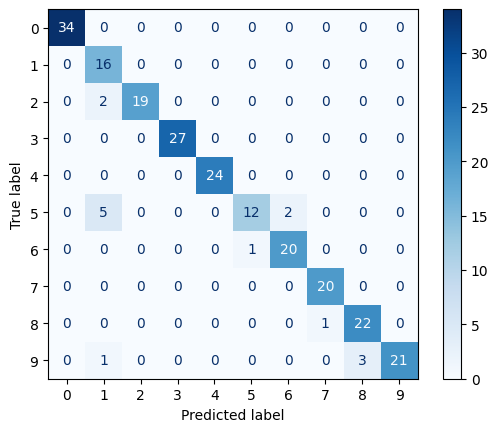


 Epoch 1: Learning Rate = 0.001
Subject 13 | Epoch 1/200 | Train Loss: 2.1237 | Train Acc: 0.2418 | Val Loss: 2.0586 | Val Acc: 0.2853

 Epoch 2: Learning Rate = 0.001
Subject 13 | Epoch 2/200 | Train Loss: 1.6910 | Train Acc: 0.3829 | Val Loss: 1.5011 | Val Acc: 0.4400

 Epoch 3: Learning Rate = 0.001
Subject 13 | Epoch 3/200 | Train Loss: 1.3867 | Train Acc: 0.5087 | Val Loss: 1.3010 | Val Acc: 0.5147

 Epoch 4: Learning Rate = 0.001
Subject 13 | Epoch 4/200 | Train Loss: 1.1995 | Train Acc: 0.5751 | Val Loss: 0.9462 | Val Acc: 0.6907

 Epoch 5: Learning Rate = 0.001
Subject 13 | Epoch 5/200 | Train Loss: 1.0378 | Train Acc: 0.6317 | Val Loss: 0.9179 | Val Acc: 0.6507

 Epoch 6: Learning Rate = 0.001
Subject 13 | Epoch 6/200 | Train Loss: 0.9298 | Train Acc: 0.6639 | Val Loss: 0.8228 | Val Acc: 0.7173

 Epoch 7: Learning Rate = 0.001
Subject 13 | Epoch 7/200 | Train Loss: 0.8429 | Train Acc: 0.7093 | Val Loss: 0.6748 | Val Acc: 0.7413

 Epoch 8: Learning Rate = 0.001
Subject 13 | Ep

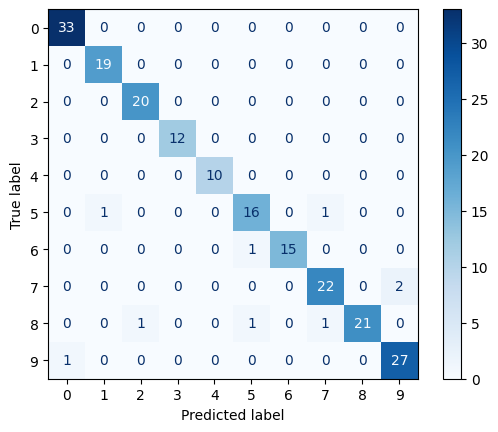


 Epoch 1: Learning Rate = 0.001
Subject 14 | Epoch 1/200 | Train Loss: 2.1578 | Train Acc: 0.1947 | Val Loss: 2.1292 | Val Acc: 0.2434

 Epoch 2: Learning Rate = 0.001
Subject 14 | Epoch 2/200 | Train Loss: 1.7927 | Train Acc: 0.3532 | Val Loss: 1.4916 | Val Acc: 0.5000

 Epoch 3: Learning Rate = 0.001
Subject 14 | Epoch 3/200 | Train Loss: 1.4371 | Train Acc: 0.4883 | Val Loss: 1.1170 | Val Acc: 0.6053

 Epoch 4: Learning Rate = 0.001
Subject 14 | Epoch 4/200 | Train Loss: 1.1558 | Train Acc: 0.5935 | Val Loss: 0.9764 | Val Acc: 0.6754

 Epoch 5: Learning Rate = 0.001
Subject 14 | Epoch 5/200 | Train Loss: 1.0121 | Train Acc: 0.6335 | Val Loss: 1.0162 | Val Acc: 0.6579

 Epoch 6: Learning Rate = 0.001
Subject 14 | Epoch 6/200 | Train Loss: 0.9403 | Train Acc: 0.6772 | Val Loss: 0.8226 | Val Acc: 0.6842

 Epoch 7: Learning Rate = 0.001
Subject 14 | Epoch 7/200 | Train Loss: 0.8085 | Train Acc: 0.7204 | Val Loss: 0.7842 | Val Acc: 0.7149

 Epoch 8: Learning Rate = 0.001
Subject 14 | Ep

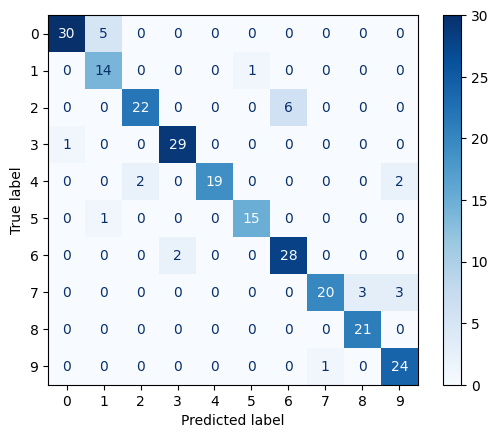


 Epoch 1: Learning Rate = 0.001
Subject 15 | Epoch 1/200 | Train Loss: 2.1141 | Train Acc: 0.2376 | Val Loss: 2.0641 | Val Acc: 0.2882

 Epoch 2: Learning Rate = 0.001
Subject 15 | Epoch 2/200 | Train Loss: 1.6021 | Train Acc: 0.4377 | Val Loss: 1.3724 | Val Acc: 0.5204

 Epoch 3: Learning Rate = 0.001
Subject 15 | Epoch 3/200 | Train Loss: 1.2169 | Train Acc: 0.5830 | Val Loss: 0.9929 | Val Acc: 0.6688

 Epoch 4: Learning Rate = 0.001
Subject 15 | Epoch 4/200 | Train Loss: 0.9941 | Train Acc: 0.6630 | Val Loss: 0.9587 | Val Acc: 0.6710

 Epoch 5: Learning Rate = 0.001
Subject 15 | Epoch 5/200 | Train Loss: 0.8251 | Train Acc: 0.7185 | Val Loss: 0.7561 | Val Acc: 0.7548

 Epoch 6: Learning Rate = 0.001
Subject 15 | Epoch 6/200 | Train Loss: 0.8007 | Train Acc: 0.7263 | Val Loss: 0.8144 | Val Acc: 0.7376

 Epoch 7: Learning Rate = 0.001
Subject 15 | Epoch 7/200 | Train Loss: 0.7361 | Train Acc: 0.7553 | Val Loss: 0.6486 | Val Acc: 0.7806

 Epoch 8: Learning Rate = 0.001
Subject 15 | Ep

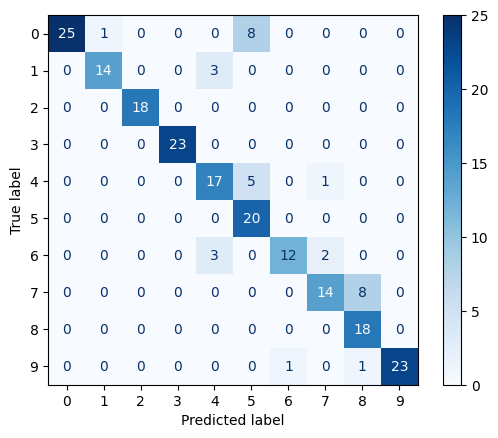


 Epoch 1: Learning Rate = 0.001
Subject 16 | Epoch 1/200 | Train Loss: 2.0377 | Train Acc: 0.2761 | Val Loss: 2.0407 | Val Acc: 0.3325

 Epoch 2: Learning Rate = 0.001
Subject 16 | Epoch 2/200 | Train Loss: 1.6042 | Train Acc: 0.4149 | Val Loss: 1.3460 | Val Acc: 0.5189

 Epoch 3: Learning Rate = 0.001
Subject 16 | Epoch 3/200 | Train Loss: 1.2648 | Train Acc: 0.5634 | Val Loss: 1.0881 | Val Acc: 0.6045

 Epoch 4: Learning Rate = 0.001
Subject 16 | Epoch 4/200 | Train Loss: 1.0124 | Train Acc: 0.6519 | Val Loss: 0.9037 | Val Acc: 0.6423

 Epoch 5: Learning Rate = 0.001
Subject 16 | Epoch 5/200 | Train Loss: 0.9130 | Train Acc: 0.6729 | Val Loss: 0.9457 | Val Acc: 0.6625

 Epoch 6: Learning Rate = 0.001
Subject 16 | Epoch 6/200 | Train Loss: 0.8481 | Train Acc: 0.7074 | Val Loss: 0.8143 | Val Acc: 0.7128

 Epoch 7: Learning Rate = 0.001
Subject 16 | Epoch 7/200 | Train Loss: 0.7957 | Train Acc: 0.7359 | Val Loss: 0.8386 | Val Acc: 0.7154

 Epoch 8: Learning Rate = 0.001
Subject 16 | Ep

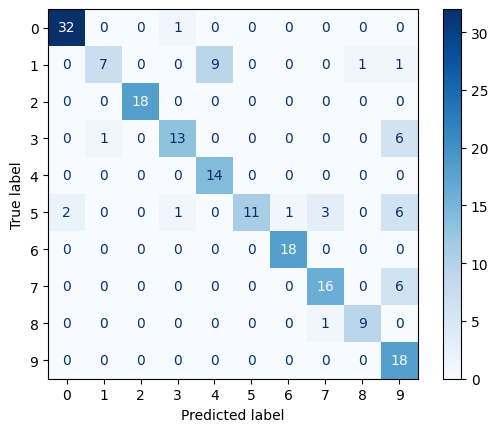


 Epoch 1: Learning Rate = 0.001
Subject 17 | Epoch 1/200 | Train Loss: 2.1174 | Train Acc: 0.2447 | Val Loss: 2.0787 | Val Acc: 0.2758

 Epoch 2: Learning Rate = 0.001
Subject 17 | Epoch 2/200 | Train Loss: 1.6137 | Train Acc: 0.4266 | Val Loss: 1.4188 | Val Acc: 0.5011

 Epoch 3: Learning Rate = 0.001
Subject 17 | Epoch 3/200 | Train Loss: 1.2999 | Train Acc: 0.5631 | Val Loss: 1.0740 | Val Acc: 0.6547

 Epoch 4: Learning Rate = 0.001
Subject 17 | Epoch 4/200 | Train Loss: 1.0611 | Train Acc: 0.6381 | Val Loss: 0.9480 | Val Acc: 0.6863

 Epoch 5: Learning Rate = 0.001
Subject 17 | Epoch 5/200 | Train Loss: 0.9728 | Train Acc: 0.6662 | Val Loss: 0.8823 | Val Acc: 0.7011

 Epoch 6: Learning Rate = 0.001
Subject 17 | Epoch 6/200 | Train Loss: 0.8689 | Train Acc: 0.7220 | Val Loss: 0.8321 | Val Acc: 0.7411

 Epoch 7: Learning Rate = 0.001
Subject 17 | Epoch 7/200 | Train Loss: 0.8060 | Train Acc: 0.7322 | Val Loss: 0.7362 | Val Acc: 0.7516

 Epoch 8: Learning Rate = 0.001
Subject 17 | Ep

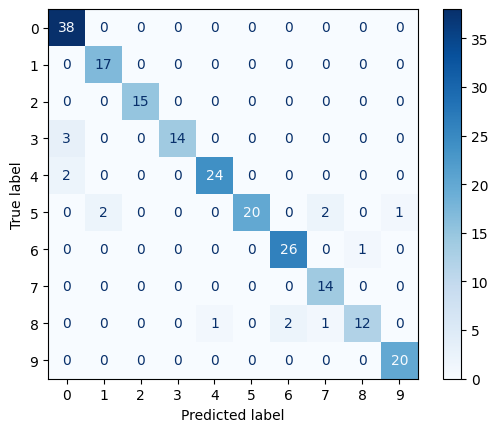


 Epoch 1: Learning Rate = 0.001
Subject 18 | Epoch 1/200 | Train Loss: 2.0963 | Train Acc: 0.2360 | Val Loss: 1.9704 | Val Acc: 0.3592

 Epoch 2: Learning Rate = 0.001
Subject 18 | Epoch 2/200 | Train Loss: 1.5751 | Train Acc: 0.4652 | Val Loss: 1.2194 | Val Acc: 0.5364

 Epoch 3: Learning Rate = 0.001
Subject 18 | Epoch 3/200 | Train Loss: 1.2120 | Train Acc: 0.5872 | Val Loss: 0.8342 | Val Acc: 0.6845

 Epoch 4: Learning Rate = 0.001
Subject 18 | Epoch 4/200 | Train Loss: 1.0364 | Train Acc: 0.6328 | Val Loss: 0.6711 | Val Acc: 0.7476

 Epoch 5: Learning Rate = 0.001
Subject 18 | Epoch 5/200 | Train Loss: 0.8815 | Train Acc: 0.6969 | Val Loss: 0.6254 | Val Acc: 0.7403

 Epoch 6: Learning Rate = 0.001
Subject 18 | Epoch 6/200 | Train Loss: 0.8590 | Train Acc: 0.7147 | Val Loss: 0.5911 | Val Acc: 0.7573

 Epoch 7: Learning Rate = 0.001
Subject 18 | Epoch 7/200 | Train Loss: 0.7839 | Train Acc: 0.7332 | Val Loss: 0.5300 | Val Acc: 0.8010

 Epoch 8: Learning Rate = 0.001
Subject 18 | Ep

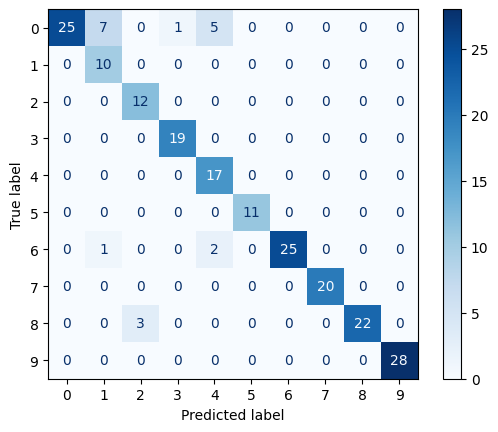


 Epoch 1: Learning Rate = 0.001
Subject 19 | Epoch 1/200 | Train Loss: 2.1216 | Train Acc: 0.2072 | Val Loss: 2.0904 | Val Acc: 0.2623

 Epoch 2: Learning Rate = 0.001
Subject 19 | Epoch 2/200 | Train Loss: 1.6284 | Train Acc: 0.4076 | Val Loss: 1.3004 | Val Acc: 0.5574

 Epoch 3: Learning Rate = 0.001
Subject 19 | Epoch 3/200 | Train Loss: 1.3273 | Train Acc: 0.5241 | Val Loss: 1.0544 | Val Acc: 0.6762

 Epoch 4: Learning Rate = 0.001
Subject 19 | Epoch 4/200 | Train Loss: 1.1440 | Train Acc: 0.5924 | Val Loss: 0.9151 | Val Acc: 0.7049

 Epoch 5: Learning Rate = 0.001
Subject 19 | Epoch 5/200 | Train Loss: 1.0437 | Train Acc: 0.6405 | Val Loss: 0.9025 | Val Acc: 0.6988

 Epoch 6: Learning Rate = 0.001
Subject 19 | Epoch 6/200 | Train Loss: 0.9425 | Train Acc: 0.6764 | Val Loss: 0.7554 | Val Acc: 0.7561

 Epoch 7: Learning Rate = 0.001
Subject 19 | Epoch 7/200 | Train Loss: 0.8567 | Train Acc: 0.7049 | Val Loss: 0.7679 | Val Acc: 0.7500

 Epoch 8: Learning Rate = 0.001
Subject 19 | Ep

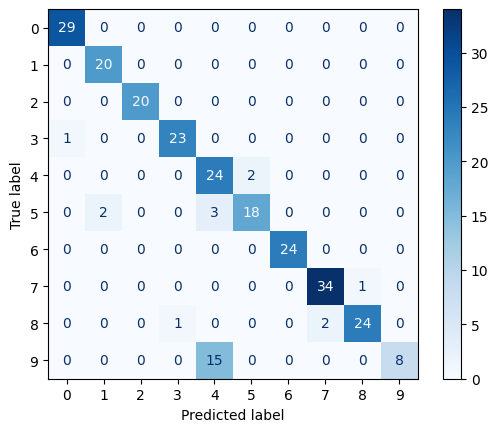


 Epoch 1: Learning Rate = 0.001
Subject 20 | Epoch 1/200 | Train Loss: 2.1150 | Train Acc: 0.2369 | Val Loss: 2.0641 | Val Acc: 0.2610

 Epoch 2: Learning Rate = 0.001
Subject 20 | Epoch 2/200 | Train Loss: 1.5708 | Train Acc: 0.4257 | Val Loss: 1.2450 | Val Acc: 0.5132

 Epoch 3: Learning Rate = 0.001
Subject 20 | Epoch 3/200 | Train Loss: 1.1839 | Train Acc: 0.5587 | Val Loss: 0.9293 | Val Acc: 0.6294

 Epoch 4: Learning Rate = 0.001
Subject 20 | Epoch 4/200 | Train Loss: 1.0078 | Train Acc: 0.6275 | Val Loss: 0.7511 | Val Acc: 0.7259

 Epoch 5: Learning Rate = 0.001
Subject 20 | Epoch 5/200 | Train Loss: 0.8826 | Train Acc: 0.6866 | Val Loss: 0.6520 | Val Acc: 0.7763

 Epoch 6: Learning Rate = 0.001
Subject 20 | Epoch 6/200 | Train Loss: 0.7740 | Train Acc: 0.7346 | Val Loss: 0.5809 | Val Acc: 0.7895

 Epoch 7: Learning Rate = 0.001
Subject 20 | Epoch 7/200 | Train Loss: 0.7429 | Train Acc: 0.7508 | Val Loss: 0.5468 | Val Acc: 0.8268

 Epoch 8: Learning Rate = 0.001
Subject 20 | Ep

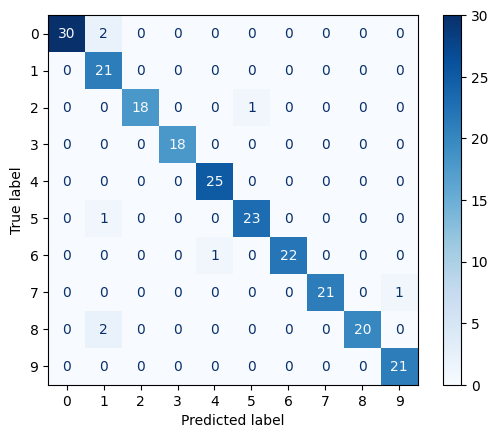


 Epoch 1: Learning Rate = 0.001
Subject 21 | Epoch 1/200 | Train Loss: 2.1005 | Train Acc: 0.2295 | Val Loss: 1.9836 | Val Acc: 0.3007

 Epoch 2: Learning Rate = 0.001
Subject 21 | Epoch 2/200 | Train Loss: 1.5045 | Train Acc: 0.4994 | Val Loss: 1.1950 | Val Acc: 0.6296

 Epoch 3: Learning Rate = 0.001
Subject 21 | Epoch 3/200 | Train Loss: 0.9470 | Train Acc: 0.6917 | Val Loss: 0.7504 | Val Acc: 0.7712

 Epoch 4: Learning Rate = 0.001
Subject 21 | Epoch 4/200 | Train Loss: 0.7448 | Train Acc: 0.7372 | Val Loss: 0.6345 | Val Acc: 0.8039

 Epoch 5: Learning Rate = 0.001
Subject 21 | Epoch 5/200 | Train Loss: 0.5937 | Train Acc: 0.7904 | Val Loss: 0.5976 | Val Acc: 0.8126

 Epoch 6: Learning Rate = 0.001
Subject 21 | Epoch 6/200 | Train Loss: 0.5320 | Train Acc: 0.8167 | Val Loss: 0.5491 | Val Acc: 0.8410

 Epoch 7: Learning Rate = 0.001
Subject 21 | Epoch 7/200 | Train Loss: 0.4652 | Train Acc: 0.8468 | Val Loss: 0.5672 | Val Acc: 0.8453

 Epoch 8: Learning Rate = 0.001
Subject 21 | Ep

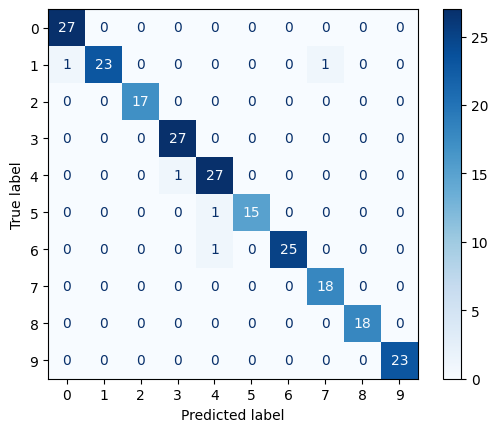


 Epoch 1: Learning Rate = 0.001
Subject 22 | Epoch 1/200 | Train Loss: 2.1225 | Train Acc: 0.2232 | Val Loss: 2.1086 | Val Acc: 0.2375

 Epoch 2: Learning Rate = 0.001
Subject 22 | Epoch 2/200 | Train Loss: 1.4589 | Train Acc: 0.4711 | Val Loss: 1.0548 | Val Acc: 0.6253

 Epoch 3: Learning Rate = 0.001
Subject 22 | Epoch 3/200 | Train Loss: 1.0677 | Train Acc: 0.5707 | Val Loss: 0.7585 | Val Acc: 0.7211

 Epoch 4: Learning Rate = 0.001
Subject 22 | Epoch 4/200 | Train Loss: 0.9067 | Train Acc: 0.6658 | Val Loss: 0.6075 | Val Acc: 0.7974

 Epoch 5: Learning Rate = 0.001
Subject 22 | Epoch 5/200 | Train Loss: 0.7517 | Train Acc: 0.7343 | Val Loss: 0.5521 | Val Acc: 0.8105

 Epoch 6: Learning Rate = 0.001
Subject 22 | Epoch 6/200 | Train Loss: 0.7083 | Train Acc: 0.7540 | Val Loss: 0.4841 | Val Acc: 0.8410

 Epoch 7: Learning Rate = 0.001
Subject 22 | Epoch 7/200 | Train Loss: 0.6023 | Train Acc: 0.7907 | Val Loss: 0.4210 | Val Acc: 0.8540

 Epoch 8: Learning Rate = 0.001
Subject 22 | Ep

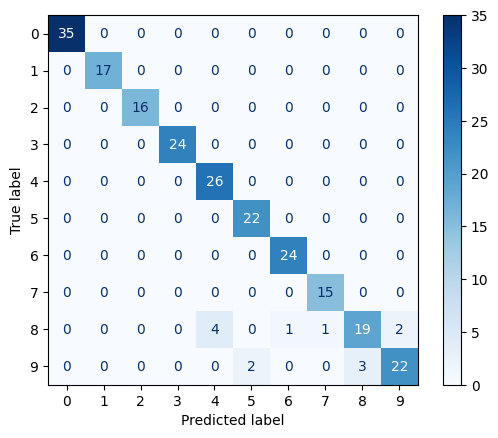


 Epoch 1: Learning Rate = 0.001
Subject 23 | Epoch 1/200 | Train Loss: 2.1189 | Train Acc: 0.2220 | Val Loss: 2.0495 | Val Acc: 0.3151

 Epoch 2: Learning Rate = 0.001
Subject 23 | Epoch 2/200 | Train Loss: 1.5578 | Train Acc: 0.4485 | Val Loss: 1.1987 | Val Acc: 0.6513

 Epoch 3: Learning Rate = 0.001
Subject 23 | Epoch 3/200 | Train Loss: 1.1139 | Train Acc: 0.6139 | Val Loss: 0.9640 | Val Acc: 0.6828

 Epoch 4: Learning Rate = 0.001
Subject 23 | Epoch 4/200 | Train Loss: 0.8686 | Train Acc: 0.7027 | Val Loss: 0.8218 | Val Acc: 0.6975

 Epoch 5: Learning Rate = 0.001
Subject 23 | Epoch 5/200 | Train Loss: 0.7878 | Train Acc: 0.7124 | Val Loss: 0.6964 | Val Acc: 0.7773

 Epoch 6: Learning Rate = 0.001
Subject 23 | Epoch 6/200 | Train Loss: 0.6944 | Train Acc: 0.7510 | Val Loss: 0.7176 | Val Acc: 0.7731

 Epoch 7: Learning Rate = 0.001
Subject 23 | Epoch 7/200 | Train Loss: 0.6322 | Train Acc: 0.7786 | Val Loss: 0.6169 | Val Acc: 0.7920

 Epoch 8: Learning Rate = 0.001
Subject 23 | Ep

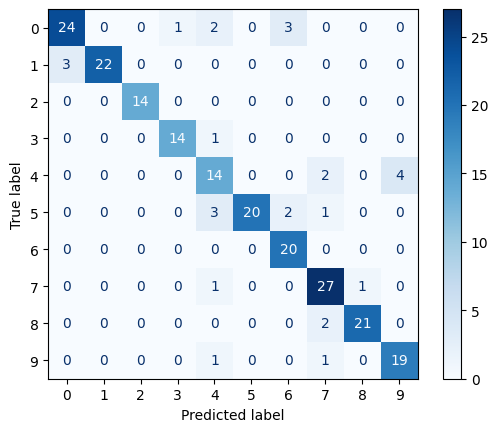


 Epoch 1: Learning Rate = 0.001
Subject 24 | Epoch 1/200 | Train Loss: 2.0734 | Train Acc: 0.2921 | Val Loss: 1.9748 | Val Acc: 0.3341

 Epoch 2: Learning Rate = 0.001
Subject 24 | Epoch 2/200 | Train Loss: 1.4451 | Train Acc: 0.5037 | Val Loss: 1.1691 | Val Acc: 0.6411

 Epoch 3: Learning Rate = 0.001
Subject 24 | Epoch 3/200 | Train Loss: 1.0246 | Train Acc: 0.6239 | Val Loss: 0.8135 | Val Acc: 0.6975

 Epoch 4: Learning Rate = 0.001
Subject 24 | Epoch 4/200 | Train Loss: 0.9070 | Train Acc: 0.6830 | Val Loss: 0.6838 | Val Acc: 0.7675

 Epoch 5: Learning Rate = 0.001
Subject 24 | Epoch 5/200 | Train Loss: 0.8195 | Train Acc: 0.7085 | Val Loss: 0.6143 | Val Acc: 0.7743

 Epoch 6: Learning Rate = 0.001
Subject 24 | Epoch 6/200 | Train Loss: 0.7244 | Train Acc: 0.7475 | Val Loss: 0.6631 | Val Acc: 0.7652

 Epoch 7: Learning Rate = 0.001
Subject 24 | Epoch 7/200 | Train Loss: 0.6586 | Train Acc: 0.7737 | Val Loss: 0.5805 | Val Acc: 0.8262

 Epoch 8: Learning Rate = 0.001
Subject 24 | Ep

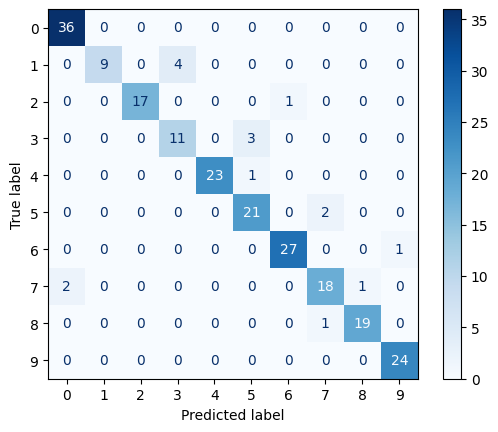


 Epoch 1: Learning Rate = 0.001
Subject 25 | Epoch 1/200 | Train Loss: 2.0758 | Train Acc: 0.2674 | Val Loss: 2.0170 | Val Acc: 0.2613

 Epoch 2: Learning Rate = 0.001
Subject 25 | Epoch 2/200 | Train Loss: 1.4565 | Train Acc: 0.5103 | Val Loss: 1.1825 | Val Acc: 0.6609

 Epoch 3: Learning Rate = 0.001
Subject 25 | Epoch 3/200 | Train Loss: 1.0621 | Train Acc: 0.6518 | Val Loss: 0.8163 | Val Acc: 0.7430

 Epoch 4: Learning Rate = 0.001
Subject 25 | Epoch 4/200 | Train Loss: 0.8376 | Train Acc: 0.7074 | Val Loss: 0.6252 | Val Acc: 0.7991

 Epoch 5: Learning Rate = 0.001
Subject 25 | Epoch 5/200 | Train Loss: 0.7371 | Train Acc: 0.7364 | Val Loss: 0.5868 | Val Acc: 0.7905

 Epoch 6: Learning Rate = 0.001
Subject 25 | Epoch 6/200 | Train Loss: 0.6654 | Train Acc: 0.7726 | Val Loss: 0.5660 | Val Acc: 0.8099

 Epoch 7: Learning Rate = 0.001
Subject 25 | Epoch 7/200 | Train Loss: 0.6295 | Train Acc: 0.7829 | Val Loss: 0.5927 | Val Acc: 0.7927

 Epoch 8: Learning Rate = 0.001
Subject 25 | Ep

# Simplest Model

In [ ]:
class simplestCNN(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(simplestCNN, self).__init__()
        self.conv1 = nn.Conv1d(input_channels, 32, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm1d(32)

        self.conv2 = nn.Conv1d(32, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm1d(64)

        self.pool = nn.MaxPool1d(kernel_size=2, stride=2, padding=0)

        self.attn = SelfAttentionBlock(64, 4)

        self.global_avg_pool = nn.AdaptiveAvgPool1d(1)
        self.fc1 = nn.Linear(64, 128)
        self.out = nn.Linear(128, num_classes)

        self.dropout1 = nn.Dropout(0.2)
        self.dropout2 = nn.Dropout(0.3)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)

        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = self.dropout1(x)

        x = self.attn(x)

        x = self.global_avg_pool(x).squeeze(-1)

        x = F.relu(self.fc1(x))
        x = self.dropout2(x)

        x = self.out(x)
        return x

#Complex CNN model

In [ ]:
from typing_extensions import Self
class complexCNN(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(complexCNN, self).__init__()
        self.conv1 = nn.Conv1d(input_channels, 32, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm1d(32)

        self.conv2 = nn.Conv1d(32, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm1d(64)

        self.conv3 = nn.Conv1d(64, 128, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn3 = nn.BatchNorm1d(128)

        self.conv4 = nn.Conv1d(128, 256, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn4 = nn.BatchNorm1d(256)

        self.pool = nn.MaxPool1d(kernel_size=2, stride=2, padding=0)

        self.attn = SelfAttentionBlock(256, 4)

        self.global_avg_pool = nn.AdaptiveAvgPool1d(1)
        self.fc1 = nn.Linear(256, 512)
        self.fc2 = nn.Linear(512, 512)
        self.out = nn.Linear(512, num_classes)

        self.dropout1 = nn.Dropout(0.2)
        self.dropout2 = nn.Dropout(0.3)
        self.dropout3 = nn.Dropout(0.3)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)

        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = self.dropout1(x)

        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool(x)
        x = self.dropout2(x)

        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool(x)
        x = self.dropout2(x)

        x = self.attn(x)

        x = self.global_avg_pool(x).squeeze(-1)

        x = F.relu(self.fc1(x))
        x = self.dropout3(x)

        x = F.relu(self.fc2(x))
        x = self.dropout3(x)

        x = self.out(x)
        return x

#Training Loop

In [ ]:

#Define subject datasets to evaluate
subjects = list(range(1,28))

#Define lists to store data accumulated across multiple subjects
all_acc = []
all_train_time = []
all_test_time = []
all_train_latency = []
all_test_latency = []
all_test_loss = []

#Define learning rate scheduler
def scheduler(epoch):
    if epoch < 50:
        return 0.001
    elif 50 <= epoch < 100:
        return 0.0005
    elif 100 <= epoch < 150:
        return 0.0001
    else:
        return 0.00001


#For plotting average loss and accuracy over all subjects
epoch_metrics = defaultdict(lambda: {'loss': [], 'val_loss': [], 'accuracy': [], 'val_accuracy': []})

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#Iterate through subjects
for subject in subjects:

    #Retreive input sEMG feature data and target labels from CSV files
    #CHANGE THIS to get different types of data when needed
    inputs, targets = inputstargets(subject,"train")
    val_inputs, val_targets = inputstargets(subject,"validation")
    test_inputs, test_targets = inputstargets(subject,"test")

    inputs = np.array(inputs)
    val_inputs = np.array(val_inputs)
    test_inputs = np.array(test_inputs)

    if inputs.ndim == 3:
        inputs = inputs.transpose(0, 2, 1)
        val_inputs = val_inputs.transpose(0, 2, 1)
        test_inputs = test_inputs.transpose(0, 2, 1)

    inputs = torch.tensor(inputs, dtype=torch.float32)
    val_inputs = torch.tensor(val_inputs, dtype=torch.float32)
    test_inputs = torch.tensor(test_inputs, dtype=torch.float32)

    targets = torch.tensor(targets, dtype=torch.long)
    val_targets = torch.tensor(val_targets, dtype=torch.long)
    test_targets = torch.tensor(test_targets, dtype=torch.long)

    train_dataset = TensorDataset(inputs, targets)
    val_dataset = TensorDataset(val_inputs, val_targets)
    test_dataset = TensorDataset(test_inputs, test_targets)

    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=64)
    test_loader = DataLoader(test_dataset, batch_size=64)

    #Initiate type of model - Change depending on model we are testing
    model = middleCNN(input_channels=inputs.shape[1], num_classes=10).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    train_time_start = time.time()

    #Training loop
    for epoch in range(200):
        model.train()
        total_loss = 0
        correct = 0
        total = 0
        lr = scheduler(epoch)
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr
        print(f"\n Epoch {epoch+1}: Learning Rate = {lr}")

        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            outputs = model(xb)
            loss = criterion(outputs, yb)
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * xb.size(0)
            _, predicted = outputs.max(1)
            correct += predicted.eq(yb).sum().item()
            total += yb.size(0)

        train_loss = total_loss / total
        train_acc = correct / total

        model.eval()
        val_loss, val_correct, val_total = 0, 0, 0
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                outputs = model(xb)
                loss = criterion(outputs, yb)

                val_loss += loss.item() * xb.size(0)
                _, predicted = outputs.max(1)
                val_correct += predicted.eq(yb).sum().item()
                val_total += yb.size(0)

        val_loss /= val_total
        val_acc = val_correct / val_total

        print(f"Subject {subject} | Epoch {epoch+1}/200 | "
              f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | "
              f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")


        epoch_metrics[epoch]['loss'].append(train_loss)
        epoch_metrics[epoch]['val_loss'].append(val_loss)
        epoch_metrics[epoch]['accuracy'].append(train_acc)
        epoch_metrics[epoch]['val_accuracy'].append(val_acc)

    train_time = time.time() - train_time_start
    model.eval()
    correct, total = 0, 0
    test_loss = 0
    Actual_Class, Predicted_Class = [], []

    test_start_time = time.time()
    with torch.no_grad():
        for xb, yb in test_loader:
            xb, yb = xb.to(device), yb.to(device)
            outputs = model(xb)
            loss = criterion(outputs, yb)
            test_loss += loss.item() * xb.size(0)

            _, predicted = outputs.max(1)
            correct += predicted.eq(yb).sum().item()
            total += yb.size(0)

            Predicted_Class.extend(predicted.cpu().tolist())
            Actual_Class.extend(yb.cpu().tolist())

    test_time = time.time() - test_start_time
    test_loss /= total

    print(f"Subject {subject} | Test Accuracy: {correct / total:.4f} | Test Loss: {test_loss:.4f}")


    all_acc.append(correct / total)
    all_train_time.append(train_time)
    all_test_time.append(test_time)
    all_test_loss.append(test_loss)

    train_latency = train_time / len(train_dataset)
    test_latency = test_time / len(test_dataset)
    all_train_latency.append(train_latency)
    all_test_latency.append(test_latency)

    print(classification_report(Actual_Class, Predicted_Class))
    disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(Actual_Class, Predicted_Class), display_labels=[str(i) for i in range(10)])
    disp.plot(cmap="Blues")
    plt.show()

#Save individual test results to a CSV
with open("individual_test_results_TD_10_AttentionCNN1.csv", 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(['Subject', 'Test Accuracy', 'Test Loss', 'Test Time', 'Train Latency', 'Test Latency'])

    for i, subject in enumerate(subjects):
        writer.writerow([subject, all_acc[i], all_test_loss[i], all_test_time[i], all_train_latency[i], all_test_latency[i]])

print("Individual test results have been saved to 'individual_test_results_TD_10_AttentionCNN1.csv'.")

#Average metrics per epoch
avg_metrics = {
    'loss': [np.mean(epoch_metrics[e]['loss']) for e in sorted(epoch_metrics)],
    'val_loss': [np.mean(epoch_metrics[e]['val_loss']) for e in sorted(epoch_metrics)],
    'accuracy': [np.mean(epoch_metrics[e]['accuracy']) for e in sorted(epoch_metrics)],
    'val_accuracy': [np.mean(epoch_metrics[e]['val_accuracy']) for e in sorted(epoch_metrics)],
}

avg_metrics_df = pd.DataFrame(avg_metrics)
avg_metrics_df.to_csv("avg_metrics_per_epoch_TD_10_AttentionCNN1.csv", index_label="epoch")

!cp /content/avg_metrics_per_epoch_TD_10_AttentionCNN1.csv /content/drive/MyDrive/Models
!cp /content/individual_test_results_TD_10_AttentionCNN1.csv /content/drive/MyDrive/Models

plt.figure()
plt.plot(avg_metrics_df['loss'], label='Avg Training Loss')
plt.plot(avg_metrics_df['val_loss'], label='Avg Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Average Loss vs Epoch")
plt.show()

plt.figure()
plt.plot(avg_metrics_df['accuracy'], label='Avg Training Acc')
plt.plot(avg_metrics_df['val_accuracy'], label='Avg Validation Acc')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Average Accuracy vs Epoch")
plt.show()